First try of getting an Amplitude vs Time Graph.

While this does achieve a graph, I was mainly just trying to understand the terms and functions of how to deal with the graph, hence heavy the commenting.

pygame 2.1.2 (SDL 2.0.18, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
number of channels = 2
length = 1.003922902494331s
44273


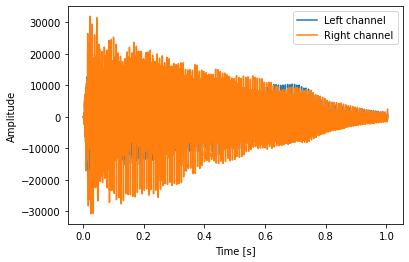

In [64]:
###import pathlib #find directory of a folder so that it works for other OSs
###import os #read the contents within folder
###------------### Only necessary when we do the searching for melody directory.


import pygame #start and stop of track playing
import scipy #has the fft <-- see OneNote page for explanation
#https://realpython.com/python-scipy-fft/
#http://www.differencebetween.net/technology/difference-between-fft-and-dft/

from scipy.io import wavfile


audio_to_identify = "C:\$$$AUDIO FILES\C3.wav"
rate, data = wavfile.read(audio_to_identify)
#mmap = False <-- file is not too large that it has to be mapped
# like any file, we have to read the information inside of it to do stuff with it.


#print(rate) #define rate: https://www.adobe.com/uk/creativecloud/video/discover/audio-sampling.html
#print(data) #define data: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
#data == the shape of the wave

##GETTING TO KNOW THE FUNCTIONS OF SCIPY TO DO WITH WAV
print(f"number of channels = {data.shape[1]}")
length = data.shape[0] / rate #whole entire audio file/ the frequency of wave
print(f"length = {length}s")
print(data.shape[0])

##PLOTTING THE WAVE!!! -- Amplitude vs Time
import matplotlib.pyplot as plt
import numpy as np
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data[:, 0], label="Left channel")
plt.plot(time, data[:, 1], label="Right channel") #which speaker sound coming out of
plt.legend() #where the key for the graph is
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

NORMALISATION -- important so sound can actually be heard. If amplitude/ power (power is the official term in programming for sound, but I use power and amplitude interchangeably as it means the same thing) is too small, then the tone will be harder to distinguish.

In [ ]:
##NORMALISATION

import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

in_wav = "C:\$$$AUDIO FILES\$$FULL_c3_major_scale.wav"
rate, data = wavfile.read(in_wav) 
##rate = data points per second
normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)
# this is the tone definition normalizes to 32k bits = standard height for the tone to be identified
#32767 = 2^15 - 1, thus putting the .WAV file into the standard 16-bit height
#[:,0] is to get the data for one channel (speaker) because both channels will have similar data
#so it does not make sense to have data from both channels.
plt.plot(normalised_tone)
plt.xlabel("Point in Time")
plt.ylabel("Amplitude")
plt.ylim([-32767, 32767])
plt.show()
#Normalized tone will be used for further analysis

CREATING LIST OF ALL NOTES ON PIANO

Realistically, especially because the aim is to take human pitch and turn that into MIDI, the possible notes a human can reach are all going to be on a piano, and even then this is a very generous range.

In [ ]:
with open("C:\$$$AUDIO FILES\TO_USE-Note_To_MIDI_Table.csv") as f:
    formatted_all_notes = []
    all_notes = [line.split() for line in f]
    for lst in all_notes[1:]:
        for elem in lst:
            elem = elem.split(",")
            for i in range (1,4):
                if i == 1 or i == 3:
                    elem[i] = int(elem[i])
                else:
                    elem[i] = float(elem[i])
            formatted_all_notes.append(elem)
print(formatted_all_notes)

FIRST FORAY INTO RFFT

This is just a short note for why rfft is used in this code. For explanation of what it does (i.e. what is Fourier Transformation), please see OneNote.

rfft is used because:
(a) fft itself is quicker than dft
(b) rfft only takes values above zero -- sound is a sine curve so both positive and negative values are included
but in this case, not necessary because it is just a mirror image so dealing with positive numbers is ok.

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq #new!!!

in_wav = "C:\$$$AUDIO FILES\C3.wav"
rate, data = wavfile.read(in_wav) 
normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)
plt.plot(normalised_tone)
plt.xlabel("Point in Time")
plt.ylabel("Amplitude")
plt.ylim([-32767, 32767])
plt.show()


# ------------------------------ #
yf = rfft(normalised_tone) #calculates the transform itself
xf = rfftfreq(len(normalised_tone), 1 / rate) #calculates the frequencies in centre of each bin in output of fft

plt.plot(xf, np.abs(yf))
plt.show()

READING ONE TONE FROM WHOLE FILE -- PIANO

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\C3.wav"

### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)
normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)

### STEP TWO: HOW TO GET TONE OF WHOLE FILE -- ONLY FOR ONE PITCH FILE

def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    # This is the number of points plotted per 1Hz of frequency.
    # The maximum frequency possibly reached is half the sample rate
    to_cut_off = int(points_per_freq * 4200) # Sets up point to cut sound off at 4200Hz because piano's highest key is 4186Hz

    yf = yf[:to_cut_off+1] # Cut off all points above 4200 Hz
    xf = xf[:to_cut_off+1]



    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]
    # This is a VERY long list of all notes on Piano. While yes, I could have kept this in a .csv file or even put this into a dictionary,
    # I wanted to have it clearly written in front of me.
    # This also makes it easier to edit and/or change the list as necessary.
    # FORMAT OF LIST: [note, MIDI, frequency, amplitude]
    # Amplitude will change depending on what will be read from the .WAV file.


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        # This is the frequency of the tone in the table.
        # Even though the sound from the file may not reach this perfect frequency, each MIDI's frequency is perfect, so
        # analysis of the sound needs to be done to find the most prominent perfect frequency.
        for j in range(to_cut_off-1):
            f1 = xf[j] #point on graph x-axis to analyse
            f2 = xf[j+1] #one ahead of point f1
            if  (f1 <= f < f2):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f2-f1)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break    
    # Method behind this:
    # Difference between power on the y-axis / Difference between two frequencies on x-axis + lower x-axis value
    # Absolute value necessary because we technically COULD come up with a negative answer due to how a sine wave looks like
    # but we do not want a negative value of frequency.
    # This is basically a glorified way of finding the average gradient between two points.
    ###---> See OneNote for more in-depth description


    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                # Tones less than 10 power/ amplitude are filtered out -- tone set to 1 as negligible sound.
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1: #finds the first tone with volume above 10
            actual_MIDI = note[1]
            break



    return actual_MIDI


single_pitch_to_MIDI(normalised_tone,rate)

READING TONE FROM ONE FILE -- HUMAN VOICE

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\VOICE_C3.wav"

### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)
if data.ndim == 2: #data.ndim returns whether 1D or 2D list, i.e. 1 channel or 2 channels
    # Had to add this in because recording from phone is only one channel, while online recording is two.
    normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)
else:
    normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### STEP TWO: HOW TO GET TONE OF WHOLE FILE -- ONLY FOR ONE PITCH FILE

def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    to_cut_off = int(points_per_freq * 4200)

    yf = yf[:to_cut_off+1]
    xf = xf[:to_cut_off+1]
    
    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        for j in range(to_cut_off-1):
            f1 = xf[j]
            f2 = xf[j+1]
            if  (f1 <= f < f2):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f2-f1)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break    

    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1:
            actual_MIDI = note[1]
            break

    return actual_MIDI


single_pitch_to_MIDI(normalised_tone,rate)

FIRST RUN: This gives the wrong output for some reason... C3 = 48

UPDATE: I sang was a C4, not a C3 like I first thought... 
Therefore, output of MIDI value 60 is correct since C4 = 60
So, therefore the code works!!!
(I will leave the voice file as VOICE_C3.WAV to show my understanding journey. It does not matter the file is named incorrectly -- I will not be using it beyond this point.)

Onwards and upwards -- trying to get each individual MIDI from multiple different notes of the same .WAV file.

METHODOLOGY ONE:
1. Put silences in whole .WAV file.
2. Take these divided parts of the .WAV file and find what the MIDI is for this sample.

UPDATE __DATE__: I have now gotten three methods, each one more accurate than the last (see evaluation in OneNote).

FIRST STEP INTO FIRST METHODOLOGY:

This is just the same function above to format a smaller list of just:
possible_tones = [Note Name, MIDI value], ...

Simple function which takes MIDI value and turns it into note names so I do not need to keep looking at a MIDI-note name table so frequently.

In [ ]:
with open("C:\$$$AUDIO FILES\ONLY_note_to_MIDI.csv") as f:
    formatted_all_notes = []
    all_notes = [line.split() for line in f]
    for lst in all_notes[1:]:
        for elem in lst:
            elem = elem.split(",")
            for i in range (1,4):
                if i == 1:
                    elem[i] = int(elem[i])
            formatted_all_notes.append(elem)
print(formatted_all_notes)

Now on to the main method!!!
Although the code below decidedly DOES work, on OneNote I have put one of my early drafts which I thought was going to work but did not. There, I have highlighted what I had to change completely (and where I spent hours looking at my code before I spotted a silly error).

In [3]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\$$FULL_c3_major_scale.wav"


### ---------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)
# I am not using data[:,0] here because we want to normalise all the sound separately before getting data from one channel.
# This is because the overall volume from both channels is going to have a different volume than just one channel
# and each channel contributes a different volume sound at a different time, therefore it makes more sense to do it all together
# then separate it.

### ---------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ---------------------------------------------------------------------------------------------------- ###
### STEP THREE: Bringing back original function for whole .WAV file to MIDI code
def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    to_cut_off = int(points_per_freq * 4200)

    yf = yf[:to_cut_off+1]
    xf = xf[:to_cut_off+1]
    
    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        for j in range(to_cut_off-1):
            f1 = xf[j]
            f2 = xf[j+1]
            if  (f1 <= f < f2):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f2-f1)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break    

    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1:
            actual_MIDI = note[1]
            break

    return actual_MIDI


### ---------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences
normalised_tone_prep_silence = [] # This will have all the silences put into it.
normalised_tone_edited = [] # This takes data from normalised_tone for one channel.

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0]) # Taking data from the left data channel.

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
        # If point has power less than 1000, the point's power is taken to be 0 because it is negligible
        # in contrast to other points around it.
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

### ---------------------------------------------------------------------------------------------------- ###
### STEP FIVE: Identifying samples from the forced silences.
bpm = 60 # beats per minute <-- easy to do 60 for now because one beat per minute.
normalised_tone_silences = []
normalised_tone_samples = []

counter = 0

# Now the file has silences built into it, we can start sampling it by these silences.
while counter < len(normalised_tone_prep_silence) - 101:
    if sum(normalised_tone_prep_silence[counter: (counter + 101)]) == 0:
        # Gap between samples have to be mroe than 100 points of 0 amplitude.
        # Keep in mind this is relatively short.
        # 100 points = 100/44100s = 0.002s (3.s.f) time
        # So as minimal data loss as possible.

        begin_silence = counter
        end_silence = counter
        counter += 100 # because we have already taken this section to be silent now.


        while (normalised_tone_prep_silence[counter] == 0) and (counter < len(normalised_tone_prep_silence)-1):
            counter += 1
            # This checks whether silence is greater than only 100 points.
        end_silence = counter
        normalised_tone_silences.append([begin_silence, end_silence])


        if len(normalised_tone_silences) >= 2:
                
                if abs(begin_silence - normalised_tone_silences[-2][1]) > (rate*60/bpm/4):
                    # EXPLANATION OF: rate*60/bpm/4
                    # This is the shortest possible tone which can be defined as a tone
                    # (number of points per second) * seconds per beat / beats per minute / 4
                    # (saying that a note has to be longer than semiquaver)
                    # One may see that 4 leaves a large area of error.
                    # This is just an arbitrary number for now -- this can be changed to be smaller.
                    normalised_tone_samples.append([normalised_tone_silences[-2][1],begin_silence])

                    
        else: # normlised_tone_silences[0][0] != 0
            if len(normalised_tone_silences) == 1:
                if (begin_silence) > (rate*60/bpm/4):
                    normalised_tone_samples.append([0,begin_silence])
            elif len(normalised_tone_silences) >= 2:
                if (begin_silence - normalised_tone_silences[-2][1]) > (rate*60/bpm/4): # same as above
                    normalised_tone_samples.append([normalised_tone_silences[-2][1],begin_silence])              

    counter += 1



all_midi_tones = [] # All MIDI notes for different samples
for i in range (len(normalised_tone_samples)):
    begin_sample = normalised_tone_samples[i][0]
    end_sample = normalised_tone_samples[i][1]

    if (end_sample - begin_sample) > (rate*60/bpm/4):
        midi_of_sample = single_pitch_to_MIDI(normalised_tone_prep_silence[begin_sample : end_sample + 1], rate)
        duration_of_sample = (end_sample - begin_sample)/rate
        all_midi_tones.append([midi_to_note_name(midi_of_sample),midi_of_sample,duration_of_sample,bpm,100])


for i in range (len(all_midi_tones)):
    print(all_midi_tones[i])

['C3', 48, 0.9407256235827665, 60, 100]
['D3', 50, 0.9956689342403628, 60, 100]
['E3', 52, 0.9913151927437641, 60, 100]
['F3', 53, 0.9333106575963719, 60, 100]
['G3', 55, 0.923968253968254, 60, 100]
['A3', 57, 0.8589795918367347, 60, 100]
['B3', 59, 0.943015873015873, 60, 100]
['C4', 60, 0.8227437641723356, 60, 100]


Now this method works because of how a piano decays, but the aim is to take human voice and see if that works.
Silences will not happen in the human voice as much, so I thought of another method.

METHODOLOGY TWO:

With a predefined Beats Per Minute, we can take samples based on time rather than silences.

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\$$FULL_c3_major_scale.wav"


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### ------------------------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ------------------------------------------------------------------------------------------------------------------- ###
### STEP THREE: Bringing back original function for whole .WAV file to MIDI code
def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    to_cut_off = int(points_per_freq * 4200)

    yf = yf[:to_cut_off+1]
    xf = xf[:to_cut_off+1]
    
    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        for j in range(to_cut_off-1):
            f1 = xf[j]
            f2 = xf[j+1]
            if  (f1 <= f < f2):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f2-f1)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break    

    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1:
            actual_MIDI = note[1]
            break

    return actual_MIDI


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences -- I still want to keep this because, even though not necessary, it is still good to have
normalised_tone_prep_silence = []
normalised_tone_edited = []

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0])

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

### ---------------------------------------------------------------------------------------------------- ###
### STEP FIVE: Identifying samples from the forced silences.


print("###TIME AREA ANALYSIS BASED ON AREAS IDENTIFIED BY BPM DIVISION STARTING FROM THE START OF THE FIRST TONE")
normalised_time_silences = []
normalised_time_samples = []
i = 0
b1=0
while normalised_tone_prep_silence[i]==0:
    i = i+1
b1 = i
b2 = len(normalised_tone_prep_silence)
counter = len(normalised_tone_prep_silence)
while normalised_tone_prep_silence[i] == 0:
    i= i - 1
b2 = i
print("b1,b2",b1,b2)
#b2 becomes the first point from which beats will be cut out to intervals
numberofbeats = int((b2-b1)/rate*bpm/60)+1
print("numberofbeats: ",numberofbeats)
msinglebybeat=[]


for i in range(numberofbeats):
    s1 = int(b1+i*rate*60/bpm)
    s2 = min((int(b1+(i+1)*rate*60/bpm),b2))
    #print("normalized_tone_left[int(b2+i*samplerate*60/BPM): ",s1,s2)
    if (s2 - s1) >(rate*60/bpm/4):
        m = single_pitch_to_MIDI(normalised_tone_prep_silence[s1:s2],rate)
        duration_of_sample = 60/BPM
        msinglebybeat.append([midi_to_note_name(m),m,duration_of_sample,bpm,100])

print("METHOD 3 = MIDI OUTPUT USING BPM LONG INTERVALS - 1 Tone per interval")
for i in range(0,len(msinglebybeat)):
    print(msinglebybeat[i])



This output, while it may avoid the issue that occurs with Method 1, it still will not be that precise if there is any semblance of syncopation across the beat. Therefore, I have developed a final methodology.

I thought I finished my project here, but alas -- the right octave was not always rightly identified.

Upon further inspection -- when I used human voice, the most powerful/ highest amplitude frequency was the frequency that corresponded to the right note, while with the piano I had to force the note down to the first note that had a high amplitude.

Due to different sound envelopes, the piano has different and more powerful overtones/ harmonics compared to the human voice. (See OneNote for more elaboration)

Thus, now I have two methods -- one for piano, and one for human voice.

Therefore -- we have a final code.